<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2_evaluators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies

!git clone https://github.com/matterport/Mask_RCNN.git

%cd Mask_RCNN
!python setup.py install
!pip show mask-rcnn

%cd ..
#!pip3 install imgaug

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 17.53 MiB/s, done.
Resolving deltas: 100% (570/570), done.
/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/

In [2]:
#@title Mount the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#@title Import Mask R-CNN dependencies

%cd Mask_RCNN/

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

from os import listdir
from xml.etree import ElementTree

%cd ..

/content/Mask_RCNN


Using TensorFlow backend.


/content


In [0]:
#@title Configurations for pre-trained joint extractors

max_instances_to_detect = 128

feet_regions = 6
hand_regions = 11

MODEL_DIR = 'logs'

class FeetJointsConfig(Config):
    # give the configuration a recognizable name
    NAME = "FeetJoints_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = feet_regions + 1
   
    # Number of training steps per epoch
    #STEPS_PER_EPOCH = 1
    #VALIDATION_STEPS = 1

    #Select backbone: resnet50 or resnet101
    BACKBONE = "resnet101"

    #Image resizing
    #IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    #IMAGE_MIN_SCALE = 2.0

    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Set lower confidence threshold
    DETECTION_MIN_CONFIDENCE = 0.0
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=feet_regions

    # max detected instances
    DETECTION_MAX_INSTANCES = max_instances_to_detect


class HandJointsConfig(Config):
    # give the configuration a recognizable name
    NAME = "HandJoints_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = hand_regions + 1
   
    # Number of training steps per epoch
    #STEPS_PER_EPOCH = max(1, train_samples // IMAGES_PER_GPU)
    #VALIDATION_STEPS = max(1, val_samples // IMAGES_PER_GPU)

    #Select backbone: resnet50 or resnet101
    BACKBONE = "resnet101"

    #Image resizing
    #IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    #IMAGE_MIN_SCALE = 2.0

    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Set lower confidence threshold
    DETECTION_MIN_CONFIDENCE = 0.0
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=hand_regions

    # max detected instances
    DETECTION_MAX_INSTANCES = max_instances_to_detect


f_config = FeetJointsConfig()
h_config = HandJointsConfig()

In [0]:
#@title Paths definition

train_set_path     = 'drive/My Drive/Work/ML/RA2/ra2/train/'
hand_detector_path = '/content/drive/My Drive/Work/ML/RA2/ra2/hands_subset/weights/model_6/mrcnn_hand_mrcnn_class_loss_best-200.hdf5'
feet_detector_path = '/content/drive/My Drive/Work/ML/RA2/ra2/feet_subset/weights/model_5/mrcnn_feet_mrcnn_class_loss_best-160.hdf5'
dataframe_path     = 'drive/My Drive/Work/ML/RA2/ra2/train/training.csv'

DENSENET121_WEIGHT_PATH_NO_TOP = '/content/drive/My Drive/Work/ML/RA2/other/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
DENSENET169_WEIGHT_PATH_NO_TOP = '/content/drive/My Drive/Work/ML/RA2/other/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5'
DENSENET201_WEIGHT_PATH_NO_TOP = '/content/drive/My Drive/Work/ML/RA2/other/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
#@title Column names per joint type

feet_detector_class_names = {
    0 : 'background',
    1 : 'mtp_1',
    2 : 'mtp_2',
    3 : 'mtp_3',
    4 : 'mtp_4',
    5 : 'mtp_5',
    6 : 'mtp_ip',
}

hand_detector_class_names = {
    0 : 'background',
    1 : 'pip_1',
    2 : 'pip_2',
    3 : 'pip_3',
    4 : 'pip_4',
    5 : 'pip_5',
    6 : 'mcp_1',
    7 : 'mcp_2',
    8 : 'mcp_3',
    9 : 'mcp_4',
    10 : 'mcp_5',
    11 : 'carp',
}

feet_left_narrowing_class_names = {
    0 : 'background',
    1 : 'LF_mtp_J__1',
    2 : 'LF_mtp_J__2',
    3 : 'LF_mtp_J__3',
    4 : 'LF_mtp_J__4',
    5 : 'LF_mtp_J__5',
    6 : 'LF_mtp_J__ip',
}

feet_right_narrowing_class_names = {
    0 : 'background',
    1 : 'RF_mtp_J__1',
    2 : 'RF_mtp_J__2',
    3 : 'RF_mtp_J__3',
    4 : 'RF_mtp_J__4',
    5 : 'RF_mtp_J__5',
    6 : 'RF_mtp_J__ip',
}

feet_left_erosion_class_names = {
    0 : 'background',
    1 : 'LF_mtp_E__1',
    2 : 'LF_mtp_E__2',
    3 : 'LF_mtp_E__3',
    4 : 'LF_mtp_E__4',
    5 : 'LF_mtp_E__5',
    6 : 'LF_mtp_E__ip',
}

feet_right_erosion_class_names = {
    0 : 'background',
    1 : 'RF_mtp_E__1',
    2 : 'RF_mtp_E__2',
    3 : 'RF_mtp_E__3',
    4 : 'RF_mtp_E__4',
    5 : 'RF_mtp_E__5',
    6 : 'RF_mtp_E__ip',
}

finger_left_erosion_names = {
    0  : 'background',
    1  : 'LH_mcp_E__ip',
    2  : 'LH_pip_E__2',
    3  : 'LH_pip_E__3',
    4  : 'LH_pip_E__4',
    5  : 'LH_pip_E__5',
    6  : 'LH_mcp_E__1',
    7  : 'LH_mcp_E__2',
    8  : 'LH_mcp_E__3',
    9  : 'LH_mcp_E__4',
    10 : 'LH_mcp_E__5',
}

finger_right_erosion_names = {
    0  : 'background',
    1  : 'RH_mcp_E__ip',
    2  : 'RH_pip_E__2',
    3  : 'RH_pip_E__3',
    4  : 'RH_pip_E__4',
    5  : 'RH_pip_E__5',
    6  : 'RH_mcp_E__1',
    7  : 'RH_mcp_E__2',
    8  : 'RH_mcp_E__3',
    9  : 'RH_mcp_E__4',
    10 : 'RH_mcp_E__5',
}

finger_left_narrowing_names = {
    0  : 'background',
    1  : 'LH_pip_J__ip', #Not needed to be evaluated
    2  : 'LH_pip_J__2',
    3  : 'LH_pip_J__3',
    4  : 'LH_pip_J__4',
    5  : 'LH_pip_J__5',
    6  : 'LH_mcp_J__1',
    7  : 'LH_mcp_J__2',
    8  : 'LH_mcp_J__3',
    9  : 'LH_mcp_J__4',
    10 : 'LH_mcp_J__5',
}

finger_right_narrowing_names = {
    0  : 'background',
    1  : 'RH_pip_J__ip', #Not needed to be evaluated
    2  : 'RH_pip_J__2',
    3  : 'RH_pip_J__3',
    4  : 'RH_pip_J__4',
    5  : 'RH_pip_J__5',
    6  : 'RH_mcp_J__1',
    7  : 'RH_mcp_J__2',
    8  : 'RH_mcp_J__3',
    9  : 'RH_mcp_J__4',
    10 : 'RH_mcp_J__5',
}

wrist_left_erosion_names = [
    'LH_wrist_E__mc1',
    'LH_wrist_E__mul',
    'LH_wrist_E__nav',
    'LH_wrist_E__radius',
    'LH_wrist_E__lunate',
    'LH_wrist_E__ulna',
]

wrist_right_erosion_names = [
    'RH_wrist_E__mc1',
    'RH_wrist_E__mul',
    'RH_wrist_E__nav',
    'RH_wrist_E__radius',
    'RH_wrist_E__lunate',
    'RH_wrist_E__ulna',
]

wrist_left_narrowing_names = [
    'LH_wrist_J__mna',
    'LH_wrist_J__capnlun',
    'LH_wrist_J__radcar',
    'LH_wrist_J__cmc3',
    'LH_wrist_J__cmc4',
    'LH_wrist_J__cmc5',
]

wrist_right_narrowing_names = [
    'RH_wrist_J__mna',
    'RH_wrist_J__capnlun',
    'RH_wrist_J__radcar',
    'RH_wrist_J__cmc3',
    'RH_wrist_J__cmc4',
    'RH_wrist_J__cmc5',
]

In [7]:
#@title Create detectors and load weights

feet_detector = modellib.MaskRCNN(mode="inference", config=f_config, model_dir=MODEL_DIR)
hand_detector = modellib.MaskRCNN(mode="inference", config=h_config, model_dir=MODEL_DIR)

feet_detector.load_weights(feet_detector_path, by_name=True)
hand_detector.load_weights(hand_detector_path, by_name=True)

feet_detector_classes = len(list(feet_detector_class_names.keys())) - 1
hand_detector_classes = len(list(hand_detector_class_names.keys())) - 1








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [8]:
#@title Read dataframe with labels

import pandas as pd
import numpy as np
import cv2

df = pd.read_csv(dataframe_path)

feet_column_names  = [ column for column in df.columns if column == 'Patient_ID' or 'RF' in column or 'LF' in column ]
feet_left_columns  = [ column for column in df.columns if column == 'Patient_ID' or 'LF' in column ]
feet_right_columns = [ column for column in df.columns if column == 'Patient_ID' or 'RF' in column ]

hand_column_names  = [ column for column in df.columns if column == 'Patient_ID' or 'RH' in column or 'LH' in column ]
hand_left_columns  = [ column for column in df.columns if column == 'Patient_ID' or 'LH' in column ]
hand_right_columns = [ column for column in df.columns if column == 'Patient_ID' or 'RH' in column ]

df.head()

,Patient_ID,Overall_Tol,Overall_erosion,Overall_narrowing,LH_mcp_E__ip,LH_pip_E__2,LH_pip_E__3,LH_pip_E__4,LH_pip_E__5,LH_mcp_E__1,LH_mcp_E__2,LH_mcp_E__3,LH_mcp_E__4,LH_mcp_E__5,LH_wrist_E__mc1,LH_wrist_E__mul,LH_wrist_E__nav,LH_wrist_E__lunate,LH_wrist_E__radius,LH_wrist_E__ulna,RH_mcp_E__ip,RH_pip_E__2,RH_pip_E__3,RH_pip_E__4,RH_pip_E__5,RH_mcp_E__1,RH_mcp_E__2,RH_mcp_E__3,RH_mcp_E__4,RH_mcp_E__5,RH_wrist_E__mc1,RH_wrist_E__mul,RH_wrist_E__nav,RH_wrist_E__lunate,RH_wrist_E__radius,RH_wrist_E__ulna,LF_mtp_E__ip,LF_mtp_E__1,LF_mtp_E__2,LF_mtp_E__3,...,LH_pip_J__4,LH_pip_J__5,LH_mcp_J__1,LH_mcp_J__2,LH_mcp_J__3,LH_mcp_J__4,LH_mcp_J__5,LH_wrist_J__cmc3,LH_wrist_J__cmc4,LH_wrist_J__cmc5,LH_wrist_J__mna,LH_wrist_J__capnlun,LH_wrist_J__radcar,RH_pip_J__2,RH_pip_J__3,RH_pip_J__4,RH_pip_J__5,RH_mcp_J__1,RH_mcp_J__2,RH_mcp_J__3,RH_mcp_J__4,RH_mcp_J__5,RH_wrist_J__cmc3,RH_wrist_J__cmc4,RH_wrist_J__cmc5,RH_wrist_J__mna,RH_wrist_J__capnlun,RH_wrist_J__radcar,LF_mtp_J__ip,LF_mtp_J__1,LF_mtp_J__2,LF_mtp_J__3,LF_mtp_J__4,LF_mtp_J__5,RF_mtp_J__ip,RF_mtp_J__1,RF_mtp_J__2,RF_mtp_J__3,RF_mtp_J__4,RF_mtp_J__5
0,UAB001,45,2,43,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,2,2,0,0,2,2,0,2,2,0,0,2,2,2,2,2,2,0,0,2,2,2,2,0,0,0,2,2,0,1,0,0,0,0,0,2,0,0,0,2
1,UAB002,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,UAB003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,UAB005,6,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,UAB006,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#@title Auxilary drawing function

import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
#@title Functions to extract regions and fix errors

from copy import deepcopy

def fix_feet_misclassification(instances):

  #Order in which missing regions will be fixed
  #Most important -> less important
  priority_order = [1, 6, 2, 3, 4, 5]

  #Define, which classes where not detected
  classes_to_detect = sorted(feet_detector_class_names.keys())[1:]
  empty_classes = set(classes_to_detect) - set(instances.keys())
  empty_classes = list(empty_classes)
  empty_classes = [ item for item in priority_order if item in empty_classes ] #Sort empty classes according to the priority order

  fixed_instances = deepcopy(instances)

  detected_instances_count = sum(
      [ len(item) for key, item in instances.items() ]
  )

  #Look for a missing region in another class's detections
  for empty_class in empty_classes:

    if empty_class == 6:#If mtp_ip not detected
      
      if(len(fixed_instances[1]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[1].pop(1) ] #Use the second activation of mtp_1
      
    elif empty_class == 1: #If mtp_1 not detected

      if(len(fixed_instances[6]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[6].pop(1) ] #Use the second activation of mtp_ip

    elif empty_class == 2:#If mtp_2 not detected
      
      if(len(fixed_instances[3]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[3].pop(1) ] #Use the second activation of mtp_3
      
      elif (len(fixed_instances[4]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[4].pop(1) ] #Use the second activation of mtp_4
    
    elif empty_class == 3:#If mtp_3 not detected, may be the most common case 
      
      if (len(fixed_instances[4]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[4].pop(1) ] #Use the second activation of mtp_4

      elif(len(fixed_instances[2]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[2].pop(1) ] #Use the second activation of mtp_2
    
    elif empty_class == 4:#If mtp_4 not detected, may be the second most common case 
      
      if (len(fixed_instances[3]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[3].pop(1) ]#Use the second activation of mtp_3

      elif(len(fixed_instances[2]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[2].pop(1) ]#Use the second activation of mtp_2

    elif empty_class == 5:#If mtp_5 not detected 
      
      if (len(fixed_instances[6]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[6].pop(1) ]#Use the second activation of mtp_ip

      elif(len(fixed_instances[1]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[1].pop(1) ]#Use the second activation of mtp_1

      elif(len(fixed_instances[4]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[4].pop(1) ]#Use the second activation of mtp_4

  return fixed_instances

def fix_hands_misclassification(instances):
  
  #Order in which missing regions will be fixed
  #Most important -> less important
  priority_order = [11, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5] #carp, mcp, pip

  #Define, which classes where not detected
  classes_to_detect = sorted(hand_detector_class_names.keys())[1:]
  empty_classes = set(classes_to_detect) - set(instances.keys())
  empty_classes = list(empty_classes)
  empty_classes = [ item for item in priority_order if item in empty_classes ] #Sort empty classes according to the priority order

  fixed_instances = deepcopy(instances)

  detected_instances_count = sum(
      [ len(item) for key, item in instances.items() ]
  )

  #Look for a missing region in another class's detections
  for empty_class in empty_classes:
    
    if empty_class == 6:#If mcp_1 not detected
      
      if(len(fixed_instances[10]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[10].pop(1) ] #Use the second activation of mcp_5
      
      elif (len(fixed_instances[1]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[1].pop(1) ] #Use the second activation of pip_1
    
    elif empty_class == 7:#If mcp_2 not detected
      
      if(len(fixed_instances[8]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[8].pop(1) ] #Use the second activation of mcp_3
      
      elif (len(fixed_instances[9]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[9].pop(1) ] #Use the second activation of mcp_4
    
    elif empty_class == 8:#If mcp_3 not detected
      
      if (len(fixed_instances[9]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[9].pop(1) ] #Use the second activation of mcp_4

      elif(len(fixed_instances[7]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[7].pop(1) ] #Use the second activation of mcp_2
    
    elif empty_class == 9:#If mcp_4 not detected 
      
      if (len(fixed_instances[8]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[8].pop(1) ]#Use the second activation of mcp_3

      elif(len(fixed_instances[7]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[7].pop(1) ]#Use the second activation of mcp_2

    elif empty_class == 10:#If mcp_5 not detected 
      
      if(len(fixed_instances[6]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[6].pop(1) ]#Use the second activation of mcp_1

      elif(len(fixed_instances[9]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[9].pop(1) ]#Use the second activation of mcp_4

    elif empty_class == 1:#If pip_1 not detected
      
      if(len(fixed_instances[6]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[6].pop(1) ] #Use the second activation of mcp_1
      
      elif (len(fixed_instances[5]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[5].pop(1) ] #Use the second activation of pip_5
    
    elif empty_class == 2:#If pip_2 not detected
      
      if(len(fixed_instances[3]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[3].pop(1) ] #Use the second activation of pip_3
      
      elif (len(fixed_instances[4]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[4].pop(1) ] #Use the second activation of pip_4
    
    elif empty_class == 3:#If pip_3 not detected
      
      if (len(fixed_instances[4]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[4].pop(1) ] #Use the second activation of pip_4

      elif(len(fixed_instances[2]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[2].pop(1) ] #Use the second activation of pip_2
    
    elif empty_class == 4:#If pip_4 not detected 
      
      if (len(fixed_instances[2]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[2].pop(1) ]#Use the second activation of pip_2

      elif(len(fixed_instances[3]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[3].pop(1) ]#Use the second activation of pip_3

    elif empty_class == 5:#If pip_5 not detected 
      
      if(len(fixed_instances[1]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[1].pop(1) ]#Use the second activation of pip_5

      elif(len(fixed_instances[6]) > 1):
        fixed_instances[empty_class] = [ fixed_instances[6].pop(1) ]#Use the second activation of mcp_1
  
  return fixed_instances

def extract_regions(detector, image, classes_num, fix_function):
  result = detector.detect([ image ], verbose=0)
  result = result[0]

  #Reshape masks from a 3d [H, W, Instances] tensor to the array of masks
  masks = []
  for i in range(result['masks'].shape[2]):
    masks.append(result['masks'][:, :, i])
  
  #Reshape dictionary to list
  result = list(zip(
      result['rois'],
      result['class_ids'],
      result['scores'],
      masks
  ))

  groupped = dict()
  
  #Group detected instances by class
  for item in result:
    roi, class_id, score, mask = item

    if class_id not in groupped.keys():
      groupped[class_id] = []
    
    groupped[class_id].append((score, roi, mask))

  #Sort each group by confidence scores
  for key in groupped.keys():
    groupped[key] = sorted(groupped[key], key = lambda x: x[0], reverse=True)

  detected_classes = len(list(groupped.keys()))


  #Ensure the model has detected all needed regions
  misclassified = False

  #Some joints may be misclassified, in most cases it may be fixed in trivial way
  if detected_classes < classes_num:
    groupped = fix_function(groupped)
    misclassified = True

  #Take max confidence result for each class as a region proposal 
  result = dict(
      [ (key, groupped[key][0]) for key in groupped.keys() ]
  )

  return result, misclassified

def convert_to_original_format(instances):
  #Reshape { class : (score, roi, mask) } dictionary to the format the results are yielded by models
  #Useful for visualization with MRCNN built-in functions
  classes, rois, scores, masks = [], [], [], []

  for key, value in instances.items():
    score, roi, mask = value

    classes.append(key)
    rois.append(roi)
    scores.append(score)
    masks.append(mask)
  
  result = {
      'rois' : np.array(rois),
      'scores' : np.array(scores),
      'class_ids' : np.array(classes),
      'masks' : np.array(masks).swapaxes(0,2).swapaxes(0,1)
  }

  return result

def extract_regions_from_image(image, result, scale=1.0):
  regions = dict()

  for class_, region in zip(result['class_ids'], result['rois']):
    #Rescale the box
    x1, y1, x2, y2, = region
    cx, cy = (x2 + x1)/2, (y2 + y1)/2
    x1, x2 = int((x1-cx) * scale + cx), int((x2-cx) * scale + cx)
    y1, y2 = int((y1-cy) * scale + cy), int((y2-cy) * scale + cy) 

    #Yes, yes, i know, y-axis is the 0 axis, but whatever
    x1, x2, y1, y2 = max(0, x1), min(x2, image.shape[0]), max(0, y1), min(y2, image.shape[1])

    regions[class_] = image[ x1:x2, y1:y2 ]

  return regions

In [0]:
hand_scale = 1.2
feet_scale = 1.2

feet_image_shape   = (64,  64,  3)
finger_image_shape = (64,  64,  3)
wrist_image_shape  = (256, 256, 3)

In [12]:
#@title Read and apply detector on all images

def apply_detectors():
  extracted_regions = dict()

  for i, p_id in zip(range(len(df['Patient_ID'])), df['Patient_ID']):
    #Save dataframe line as images metadata
    patient = {
        'info' : df[ df['Patient_ID'] == p_id ],
    }

    #Compose full image filenames
    left_foot_path  = train_set_path + p_id + '-LF.jpg'
    right_foot_path = train_set_path + p_id + '-RF.jpg'
    left_hand_path  = train_set_path + p_id + '-LH.jpg'
    right_hand_path = train_set_path + p_id + '-RH.jpg'

    #Read images
    left_foot_image  = cv2.imread(left_foot_path)
    right_foot_image = cv2.imread(right_foot_path)
    left_hand_image  = cv2.imread(left_hand_path)
    right_hand_image = cv2.imread(right_hand_path)

    #Flip right images, since extractors are trained on left/flipped right foot images
    right_foot_image = np.flip(right_foot_image, axis=1)
    right_hand_image = np.flip(right_hand_image, axis=1)

    #Detect regions on images
    left_foot_regions,  lf_mis = extract_regions(feet_detector, left_foot_image,  feet_detector_classes, fix_feet_misclassification)
    right_foot_regions, rf_mis = extract_regions(feet_detector, right_foot_image, feet_detector_classes, fix_feet_misclassification)
    left_hand_regions,  lh_mis = extract_regions(hand_detector, left_hand_image,  hand_detector_classes, fix_hands_misclassification)
    right_hand_regions, rh_mis = extract_regions(hand_detector, right_hand_image, hand_detector_classes, fix_hands_misclassification)

    #Output info about possibly badly viewed images  
    for misclassified, filename, regions in zip([lf_mis,            rf_mis,            lh_mis,             rh_mis],
                                       [left_foot_path,    right_foot_path,   left_hand_path,     right_hand_path],
                                       [left_foot_regions, right_foot_regions, left_hand_regions, right_hand_regions]):
      if misclassified:
        fixed_classes_count = len(list(regions.values()))
        print('Classified less classes than expected in file', filename + ',', fixed_classes_count, 'classes after fix')

    #Reshape a dictionary to a Matterport format, applicable for their visualization functions
    left_foot_regions  = convert_to_original_format(left_foot_regions)
    right_foot_regions = convert_to_original_format(right_foot_regions)
    left_hand_regions  = convert_to_original_format(left_hand_regions)
    right_hand_regions = convert_to_original_format(right_hand_regions)

    #Extract detected region patches from images and save them
    patient['LF'] = extract_regions_from_image(left_foot_image,  left_foot_regions,  scale=feet_scale)
    patient['RF'] = extract_regions_from_image(right_foot_image, right_foot_regions, scale=feet_scale)
    patient['LH'] = extract_regions_from_image(left_hand_image,  left_hand_regions,  scale=hand_scale)
    patient['RH'] = extract_regions_from_image(right_hand_image, right_hand_regions, scale=hand_scale)
    
    extracted_regions[p_id] = patient

    if (not ( (i + 1) % 50 )) or (i + 1) == len(df['Patient_ID']):
      print('Applied detectors on', i+1, 'UIDs')
    
  return extracted_regions

detected_regions = apply_detectors()

Applied detectors on 50 UIDs
Applied detectors on 100 UIDs
Applied detectors on 150 UIDs
Applied detectors on 200 UIDs
Applied detectors on 250 UIDs
Applied detectors on 300 UIDs
Applied detectors on 350 UIDs
Applied detectors on 368 UIDs


In [0]:
#@title Form data sets of detected regions

def form_datasets():

  foot_images     = []
  foot_erosion    = []
  foot_narrowing  = []

  hand_images     = []
  hand_erosion    = []
  hand_narrowing  = []

  wrist_images    = []
  wrist_erosion   = []
  wrist_narrowing = []

  for p_id, patient_data in sorted(
        list(
            detected_regions.items()
        ), key = lambda x: x[0]
    ):
    info = patient_data['info']

    #Resize and append left foot region images and labels
    for region_class, image in sorted(
          list(
              patient_data['LF'].items()
          ), key = lambda x: x[0]
      ):
      image = cv2.resize(image, feet_image_shape[:-1])
      erosion_score = list(
          info[ feet_left_erosion_class_names[ region_class ] ]
      )[0]

      narrowing_score = list(
          info[ feet_left_narrowing_class_names[ region_class ] ]
      )[0]

      foot_images.append(image)
      foot_erosion.append(erosion_score)
      foot_narrowing.append(narrowing_score)

    #Resize and append right foot region images and labels
    for region_class, image in sorted(
          list(
              patient_data['RF'].items()
          ), key = lambda x: x[0]
      ):
      image = cv2.resize(image, feet_image_shape[:-1])
      erosion_score = list(
          info[ feet_right_erosion_class_names[ region_class ] ]
      )[0]

      narrowing_score = list(
          info[ feet_right_narrowing_class_names[ region_class ] ]
      )[0]

      foot_images.append(image)
      foot_erosion.append(erosion_score)
      foot_narrowing.append(narrowing_score)

    #Resize and append left hand region images and labels
    #Wrist requires some different approach
    for region_class, image in sorted(
          list(
              patient_data['LH'].items()
          ), key = lambda x: x[0]
      ):
      if region_class == 11: #If a wrist image
        image = cv2.resize(image, wrist_image_shape[:-1])
        erosion_score = list(
            info[ wrist_left_erosion_names ].values.flat
        )
        narrowing_score = list(
            info[ wrist_left_narrowing_names ].values.flat
        )

        wrist_images.append(image)
        wrist_erosion.append(erosion_score)
        wrist_narrowing.append(narrowing_score)
      else:
        image = cv2.resize(image, finger_image_shape[:-1])
        erosion_score = list(
          info[ finger_left_erosion_names[ region_class ] ]
        )[0]

        #If not mcp_ip, which's narrowing is not evaluated
        if region_class != 1:
          narrowing_score = list(
            info[ finger_left_narrowing_names[ region_class ] ]
          )[0]
        else:
          narrowing_score = -1
        
        hand_narrowing.append(narrowing_score)
        hand_images.append(image)
        hand_erosion.append(erosion_score)

    for region_class, image in sorted(
          list(
              patient_data['RH'].items()
          ), key = lambda x: x[0]
      ):
      if region_class == 11: #If a wrist image
        image = cv2.resize(image, wrist_image_shape[:-1])
        erosion_score = list(
            info[ wrist_right_erosion_names ].values.flat
        )
        narrowing_score = list(
            info[ wrist_right_narrowing_names ].values.flat
        )

        wrist_images.append(image)
        wrist_erosion.append(erosion_score)
        wrist_narrowing.append(narrowing_score)
      else:
        image = cv2.resize(image, finger_image_shape[:-1])
        erosion_score = list(
          info[ finger_right_erosion_names[ region_class ] ]
        )[0]

        #If not mcp_ip, which's narrowing is not evaluated
        if region_class != 1:
          narrowing_score = list(
            info[ finger_right_narrowing_names[ region_class ] ]
          )[0]
        else:
          narrowing_score = -1
        
        hand_narrowing.append(narrowing_score)
        hand_images.append(image)
        hand_erosion.append(erosion_score)

  foot_images    = np.array(foot_images)
  foot_erosion   = np.array(foot_erosion)
  foot_narrowing = np.array(foot_narrowing)

  hand_images    = np.array(hand_images)
  hand_erosion   = np.array(hand_erosion)
  hand_narrowing = np.array(hand_narrowing)

  wrist_images   = np.array(wrist_images)
  wrist_erosion  = np.array(wrist_erosion)
  wrist_narrowing= np.array(wrist_narrowing) 

  return foot_images,  foot_erosion,  foot_narrowing, \
         hand_images,  hand_erosion,  hand_narrowing, \
         wrist_images, wrist_erosion, wrist_narrowing

In [44]:
feet_joints,   feet_erosion,    feet_narrowing, \
finger_joints, finger_erosion, finger_narrowing, \
wrist_common_joints,  wrist_common_erosion, wrist_common_narrowing = form_datasets()

feet_joints.shape,         feet_erosion.shape,         feet_narrowing.shape, \
finger_joints.shape,       finger_erosion.shape,       finger_narrowing.shape, \
wrist_common_joints.shape, wrist_common_erosion.shape, wrist_common_narrowing.shape

((4416, 64, 64, 3),
 (4416,),
 (4416,),
 (7360, 64, 64, 3),
 (7360,),
 (7360,),
 (736, 256, 256, 3),
 (736, 6),
 (736, 6))

In [0]:
hand_erosion_values = 6
hand_narrowing_values = 5

feet_erosion_values = 11
feet_narrowing_values = 5

WRIST_EROSION_OUTPUTS = [
    'mc1',
    'mul',
    'nav',
    'radius',
    'lunate',
    'ulna',
]

WRIST_NARROWING_OUTPUTS = [
    'mna',
    'capnlun',
    'radcar',
    'cmc3',
    'cmc4',
    'cmc5',
]

actual_wrist_estimator_input_shape = wrist_image_shape

In [0]:
#@title Dataset processing functions

def remove_minus_ones(data, labels):
  new_data, new_labels = [], []
  
  for i in range(len(labels)):
    if labels[i] != -1:
      new_data.append(data[i])
      new_labels.append(labels[i])
  
  return np.array(new_data), np.array(new_labels)

def normalize_labels(vector, smoothing=0.0, max_value = None):
  if max_value is None or max_value < np.max(vector):
    max_value = np.max(vector)

  vector = vector.astype(np.float64) / max_value
  
  smooth = lambda x: (0.5 + (x - 0.5) * (1 - smoothing))
  return np.array([
          smooth(value) for value in vector
  ])

def denormalize_labels(vector, max_value, smoothing=0.0):
  extend = lambda x: (0.5 + (x - 0.5) / (1 - smoothing))
  vector = np.array([ extend(value) for value in vector ]) * max_value
  return vector

def downsample_class(samples, labels, multiplier, target_class):
  _, counts = np.unique(labels, return_counts=True)
  target_count = int(counts[target_class] * multiplier)

  output_data   = []
  output_labels = []

  sampled_values = 0
  for i in range(samples.shape[0]):
    if labels[i] == target_class:
      if sampled_values >= target_count:
        pass
      else:
        sampled_values += 1
        
        output_data.append(samples[i])
        output_labels.append(labels[i])
    else:
      output_data.append(samples[i])
      output_labels.append(labels[i])

  return np.array(output_data), np.array(output_labels)

def train_test_split(data, labels, split):
  permutation = np.random.permutation(range(labels.shape[0]))
  split = int(labels.shape[0] * split)
  train_indices, val_indices = permutation[:split], permutation[split:]

  return data[train_indices], labels[train_indices], data[val_indices], labels[val_indices]

def balanced_train_test_split(data, labels, split, copy_single_instance_to_val=False):
  
  items_by_class = dict()

  for i in range(data.shape[0]):
    label = labels[i]

    if label not in items_by_class.keys():
      items_by_class[label] = []
    items_by_class[label].append(data[i])
  
  x_t, y_t, x_v, y_v = [], [], [], []

  for class_ in items_by_class.keys():
    items_by_class[class_] = np.array(items_by_class[class_])[
        np.random.permutation(range(len(items_by_class[class_])))
    ]
    items_by_class[class_] = list(items_by_class[class_])
    separator = round(len(items_by_class[class_]) * split)

    ts = items_by_class[class_][ :separator ]
    vs = items_by_class[class_][ separator: ]

    if ts == []:
      ts = np.random.choice(range(len(items_by_class[class_])))
      ts = [ items_by_class[class_][ts] ]

    if vs == [] and copy_single_instance_to_val:
      vs = np.random.choice(range(len(items_by_class[class_])))
      vs = [ items_by_class[class_][vs] ]
    
    x_t = x_t + ts
    y_t = y_t + ([ class_ ] * len(ts))

    x_v = x_v + vs
    y_v = y_v + ([ class_ ] * len(vs))

  return np.array(x_t), np.array(y_t), np.array(x_v), np.array(y_v)

def naive_oversampling(data, labels):
  labels = np.array(labels)

  classes, frequencies = np.unique(labels, return_counts=True) #labels count

  oversampled_count = np.max(frequencies) * len(frequencies) - data.shape[0] #oversampled data size

  frequencies = np.max(frequencies) * 1 / frequencies #inverse values to convert them to sampling weights
  frequencies = frequencies - frequencies[np.argmin(frequencies)]  #do not sample the most common class
  
  oversampled_data = np.zeros(
      shape = (oversampled_count,) + data.shape[1:],
      dtype = data.dtype
  )

  oversampled_labels = np.zeros(
      shape = oversampled_count,
      dtype = labels.dtype
  )

  frequencies = np.array([
            frequencies[np.argwhere( classes == class_ ).flat[0]] for class_ in labels
  ])
  frequencies = frequencies / np.sum(frequencies)

  indices = np.random.choice(data.shape[0], size = oversampled_count, p = frequencies)

  for i, index in enumerate(indices):
    oversampled_data[i] = data[index]
    oversampled_labels[i] = labels[index]

  return np.concatenate([data, oversampled_data], axis=0), np.concatenate([labels, oversampled_labels], axis=0)

def generate_folds(data, labels, folds=3):
  indices     = np.arange(len(labels))
  permutation = np.random.permutation(indices)
  
  fold_indices = []
  fold_len     = len(labels) // folds
  
  for i in range(folds):
    fold = None

    if i < folds - 1:
      fold = np.array([ permutation.pop(-1) for i in range(fold_len) ])
    else:
      fold = permutation
    
    fold_indices.append(fold)

  for fold in fold_indices:
    val_indices   = fold
    train_indices = np.array(
        [ x for x in indices if x not in val_indices ]
    )
    yield data[train_indices], labels[train_indices], \
          data[val_indices  ], labels[val_indices  ]

def normalize_multi_label(labels, max_value, smoothing=0.0):
  new_labels = []

  for label_line in labels.T:
    new_label_line = normalize_labels(label_line, smoothing, max_value)
    new_labels.append(new_label_line)
  return np.array(new_labels).T

In [0]:
#@title Modified DenseNet definition

import numpy as np

from keras import backend as K
from keras import layers
from keras import models

import keras.utils as keras_utils

from keras_applications import imagenet_utils
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import SpatialDropout2D

def dense_block(x, blocks, name, regularizer_factory):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1), regularizer_factory=regularizer_factory)
    return x

def sd_dense_block(x, blocks, name, min_dropout_rate, max_dropout_rate, regularizer_factory):
    
  bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
  
  rates = np.linspace(
      start=min_dropout_rate,
      stop=max_dropout_rate,
      num=blocks,
      endpoint=True
  )
  
  outputs = [x]
  
  for i in range(blocks):
    rates_slice = rates[:i+1]
    block_name = name + '_block' + str(i + 1)

    specific_block_input = [ SpatialDropout2D(rate)(x) for rate, x in zip(rates_slice, outputs) ]
    if len(specific_block_input) > 1:
      specific_block_input = layers.Concatenate(axis=bn_axis, name=block_name + '_concat')(specific_block_input)
    else:
      specific_block_input = specific_block_input[0]
    
    output = sd_conv_block(specific_block_input, 32, name=block_name, regularizer_factory=regularizer_factory)
    outputs = [output] + outputs

  return layers.Concatenate(axis=bn_axis, name=name + '_concat')(outputs)

def transition_block(x, reduction, name, regularizer_factory):
    
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(K.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv',
                      kernel_regularizer=regularizer_factory())(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name, regularizer_factory):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv',
                       kernel_regularizer=regularizer_factory())(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv',
                       kernel_regularizer=regularizer_factory())(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def sd_conv_block(x, growth_rate, name, regularizer_factory):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv',
                       kernel_regularizer=regularizer_factory())(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv',
                       kernel_regularizer=regularizer_factory())(x1)
                       
    return x1


def DenseNet(blocks,
             include_top=True,
             weights=DENSENET121_WEIGHT_PATH_NO_TOP,
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             blocks_to_include=3,
             include_large_conv=False,
             min_dropout_rate=0.0,
             max_dropout_rate=0.0,
             regularizer_factory=lambda: None):
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

    if include_large_conv:
      x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
      x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv', kernel_regularizer=regularizer_factory())(x)
    else:
      #new layer
      x = layers.Conv2D(64, 3, use_bias=False, padding='same', name='conv1/conv_replaced', kernel_regularizer=regularizer_factory())(img_input)
    
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
    
    if abs(max_dropout_rate) < 1e-4: #If dropout rate defined as zero, use non-dropout version
      x = dense_block(x, blocks[0], name='conv2', regularizer_factory=regularizer_factory)
      x = transition_block(x, 0.5, name='pool2',  regularizer_factory=regularizer_factory)
      x = dense_block(x, blocks[1], name='conv3', regularizer_factory=regularizer_factory)
      if blocks_to_include > 2:
        x = transition_block(x, 0.5, name='pool3',  regularizer_factory=regularizer_factory)
        x = dense_block(x, blocks[2], name='conv4', regularizer_factory=regularizer_factory)
      if blocks_to_include > 3:
        x = transition_block(x, 0.5, name='pool4',  regularizer_factory=regularizer_factory)
        x = dense_block(x, blocks[3], name='conv5', regularizer_factory=regularizer_factory)
    else: #If non-zero dropout rate, use specialized dropout blocks
      x = sd_dense_block(x, blocks[0], 'conv2', min_dropout_rate, max_dropout_rate, regularizer_factory=regularizer_factory)
      x = transition_block(x, 0.5, 'pool2', regularizer_factory=regularizer_factory)
      x = sd_dense_block(x, blocks[1], 'conv3', min_dropout_rate, max_dropout_rate, regularizer_factory=regularizer_factory)
      if blocks_to_include > 2:
        x = transition_block(x, 0.5, 'pool3', regularizer_factory=regularizer_factory)
        x = sd_dense_block(x, blocks[2], 'conv4', min_dropout_rate, max_dropout_rate, regularizer_factory=regularizer_factory)
      if blocks_to_include > 3:
        x = transition_block(x, 0.5, 'pool4', regularizer_factory=regularizer_factory)
        x = sd_dense_block(x, blocks[3], 'conv5', min_dropout_rate, max_dropout_rate, regularizer_factory=regularizer_factory)
    
    bn_name = 'bn'
    if blocks_to_include < 3:
      bn_name = 'bn_replaced'

    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=bn_name)(x)
    x = layers.Activation('relu', name='relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.

    #Compute conv layers number to name the model 'densenetX'
    
    true_blocks = blocks[:blocks_to_include]
    model_name = sum([1] + list(map(lambda x: x * 2 + 1, true_blocks)))
    model_name = 'densenet' + str(model_name)
    
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model


def ModifiedDenseNet(
      blocks_set = 121,
      weights=DENSENET121_WEIGHT_PATH_NO_TOP,
      input_shape=None,
      pooling=None,
      blocks_to_include=3,
      include_large_conv=False,
      min_dropout_rate = 0.0,
      max_dropout_rate = 0.0,
      regularizer_factory=lambda: None
    ):
    
    blocks = {
        121 : [6, 12, 24, 16],
        169 : [6, 12, 32, 32],
        201 : [6, 12, 48, 32]
    }
    if isinstance(blocks_set, list):
      blocks = blocks_set
    elif isinstance(blocks_set, int):
      if blocks_set in blocks.keys():
        blocks = blocks[blocks_set]
      else:
        raise ValueError('No such blocks set defined')
    else:
      raise ValueError('No such blocks set defined')
    
    return DenseNet(blocks,
                    False, weights,
                    None, input_shape,
                    pooling, 1000, blocks_to_include, include_large_conv, min_dropout_rate, max_dropout_rate, regularizer_factory)

In [0]:
#@title Model defining functions

import os
import tempfile
import re
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
from keras.layers import Dense, Dropout, SpatialDropout2D
from keras.models import Model
from keras.losses import categorical_crossentropy, mean_absolute_error, mean_squared_error, logcosh
from keras.optimizers import adam, sgd
from keras import regularizers
from keras.models import model_from_json
from keras.regularizers import l1, l2


def denormalized_mae(y_true, y_pred, max_value, smoothing):
  y_true = K.constant(0.5) + (y_true - K.constant(0.5))/K.constant(1 - smoothing)
  y_pred = K.constant(0.5) + (y_pred - K.constant(0.5))/K.constant(1 - smoothing)

  y_true = y_true * max_value
  y_pred = y_pred * max_value

  return mean_absolute_error(y_true, y_pred)

def denormalized_mse(y_true, y_pred, max_value, smoothing):
  y_true = K.constant(0.5) + (y_true - K.constant(0.5))/K.constant(1 - smoothing)
  y_pred = K.constant(0.5) + (y_pred - K.constant(0.5))/K.constant(1 - smoothing)

  y_true = y_true * max_value
  y_pred = y_pred * max_value

  return mean_squared_error(y_true, y_pred)

def get_denormalized_function(max_value, func_name, smoothing):
  def mae(y_true, y_pred):
    return denormalized_mae(y_true, y_pred, max_value, smoothing)

  def mse(y_true, y_pred):
    return denormalized_mse(y_true, y_pred, max_value, smoothing)

  funcs = {
      'mae' : mae,
      'mse' : mse,
  }

  return funcs[func_name]

def get_lr_metric(optimizer): #Custom metric to monitor learning rate
  def lr(y_true, y_pred):
      return optimizer.lr
  return lr

def get_feet_erosion_estimator():

  base_model = ModifiedDenseNet(
    blocks_set=121,
    weights=DENSENET121_WEIGHT_PATH_NO_TOP,
    input_shape=feet_image_shape,
    pooling='avg',
    blocks_to_include=3,
    include_large_conv=False,
    min_dropout_rate = 0.0,
    max_dropout_rate = 0.95,
    regularizer_factory=lambda: l1(1e-4)
  )
  x = base_model.output
  #x = layers.Flatten()(x)
  
  x = Dense(1, name='output', activation='sigmoid')(x)

  model = Model(inputs  = base_model.input,
                outputs = x,
                name = base_model.name
                )
  
  optimizer = adam(lr=0.0001)
  #optimizer = sgd(lr=0.0001, momentum=0.9, nesterov=True)

  lr = get_lr_metric(optimizer)
  
  mae = get_denormalized_function(feet_erosion_values - 1, 'mae', 0.0)
  mse = get_denormalized_function(feet_erosion_values - 1, 'mae', 0.0)

  metrics = [
             mean_absolute_error,
             mean_squared_error,

             mae,
             mse,

             lr
            ]
  
  model.compile(optimizer=optimizer,
                
                #loss=mean_squared_error,
                #loss=mean_absolute_error,
                loss=logcosh,

                metrics=metrics)
  
  return model

def get_wrist_erosion_estimator():
    
  base_model = ModifiedDenseNet(
    blocks_set=121,
    weights=DENSENET121_WEIGHT_PATH_NO_TOP,
    input_shape=actual_wrist_estimator_input_shape,
    pooling='avg',
    blocks_to_include=3,
    include_large_conv=False,
    min_dropout_rate = 0.0,
    max_dropout_rate = 0.95,
    regularizer_factory=lambda: l1(1e-4)
  )

  x = base_model.output
  #x = layers.Flatten()(x)

  def output_model_factory(name):
    return Dense(1, name=name, activation='sigmoid')(x)
    #x = Dense(c_num, name=name, activation='softmax')(x)
  
  output_models = dict(
      [ ( name, output_model_factory(name) ) for name in WRIST_EROSION_OUTPUTS  ]
  )

  model = Model(
      inputs  = base_model.input,
      outputs = list(output_models.values()),
      name = base_model.name
  )
  
  optimizer = adam(lr=0.0001)
  lr = get_lr_metric(optimizer)

  #Equal losses to all outputs:
  losses = dict(
      [ ( name, logcosh ) for name in WRIST_EROSION_OUTPUTS ]
  )

  #Equal loss weights for all outputs:
  loss_weights = dict(
      [ ( name, 1.0 ) for name in WRIST_EROSION_OUTPUTS ]
  )


  mae = get_denormalized_function(hand_erosion_values - 1, 'mae', 0.0)
  mse = get_denormalized_function(hand_erosion_values - 1, 'mse', 0.0)

  metrics = [
            #'accuracy',
            
            mean_absolute_error,
            mean_squared_error,
            
            mae,
            mse,

            lr
          ]
  model.compile(optimizer=optimizer,
                loss=losses,
                loss_weights=loss_weights,
                metrics=metrics)
  
  return model

TODO: All estimators


In [0]:
#Functions to apply on data before fold splitting and after fold splitting
#Pre: downsampling most frequent class
#Post: oversampling and normalizing labels to [0, 1]

TODO: Wrist processing

def data_pre_sample(data, labels, sampling_modifier = 1.0):
  classes, frequencies = np.unique(labels, return_counts=True)
  sorted_classes_frequencies = sorted(list(zip(classes, frequencies)), key = lambda x: x[1])
  
  most_frequent_class    = sorted_classes_frequencies[-1][0]
  highest_frequency     = sorted_classes_frequencies[-1][1]
  
  second_class_frequency = sorted_classes_frequencies[-2][1]
  downsample_factor = second_class_frequency / highest_frequency
  downsample_factor = max(1.0, downsample_factor * sampling_modifier) 

  return downsample_class(data, labels, downsample_factor, most_frequent_class)

def data_post_process(x_train, y_train, x_val, y_val, c_num, smoothing):
  x_train, y_train = naive_oversampling(x_train, y_train)
  x_val,   y_val   = naive_oversampling(x_val,   y_val)

  y_train = normalize_labels(y_train, max_value = c_num - 1, smoothing=smoothing)
  y_val   = normalize_labels(y_val,   max_value = c_num - 1, smoothing=smoothing)

  return x_train, y_train, x_val, y_val

def wrist_post_process(x_train, y_train, x_val, y_val, c_num, smoothing):
  y_train = normalize_multi_label(y_train, c_num - 1, smoothing)
  y_val   = normalize_multi_label(y_val,   c_num - 1, smoothing)

  return x_train, y_train, x_val, y_val

(<matplotlib.image.AxesImage at 0x7f6c2110a5f8>,
 <matplotlib.image.AxesImage at 0x7f6c1ebfd278>)

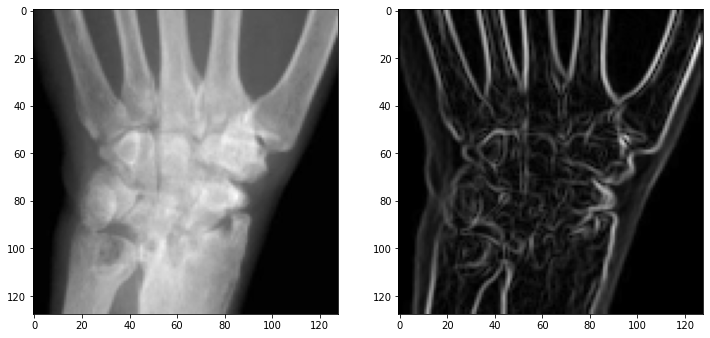

In [157]:
#@title Test filter function application

def filter_image(image, sqrt_output = True, sobel=True):
  h_k = [[1,   0, -1],
         [2,   0, -2],
         [1,   0, -1]] if sobel\
         else\
         [[1,   0, -1],
         [1,   0, -1],
         [1,   0, -1]]

  v_k = [[1,   2,  1],
         [0,   0,  0],
         [-1, -2, -1]] if sobel\
         else\
         [[1,   1,  1],
         [0,   0,  0],
         [-1, -1, -1]]

  h_k, v_k = np.array(h_k), np.array(v_k)

  h_m = cv2.filter2D(image.astype(np.float64), -1, h_k)
  v_m = cv2.filter2D(image.astype(np.float64), -1, v_k)

  m = h_m * h_m + v_m * v_m
  return np.sqrt(m) if sqrt_output else m

tmpind = np.random.choice(len(wrist_common_joints))
tmp = wrist_common_joints[tmpind]
tmp = cv2.resize(tmp, (128, 128))

tmp = (tmp, filter_image(tmp, True, True))

_, ax = plt.subplots(ncols = 2, figsize=(12, 6))

ax[0].imshow(normalize_image(tmp[0])),\
ax[1].imshow(normalize_image(tmp[1]))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

TODO: Generators for all categories

feet_erosion_train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,

    horizontal_flip = True,
    rotation_range=45,
    
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,

    dtype='float64'
)

feet_narrowing_train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,

    horizontal_flip = True,
    rotation_range=45,
    
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,

    dtype='float64'
)

hand_erosion_train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,

    horizontal_flip = True,
    rotation_range=45,
    
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,

    dtype='float64'
)

hand_narrowing_train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,

    horizontal_flip = True,
    rotation_range=45,
    
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,

    dtype='float64'
)

val_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    
    dtype='float64'
)

wrist_train_img_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    
    rotation_range=15,
    
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.9, 1],
    
    dtype='float64'
)

Displaying images normalized to [0, 1] with mean -7.947286e-08 and std 1.0


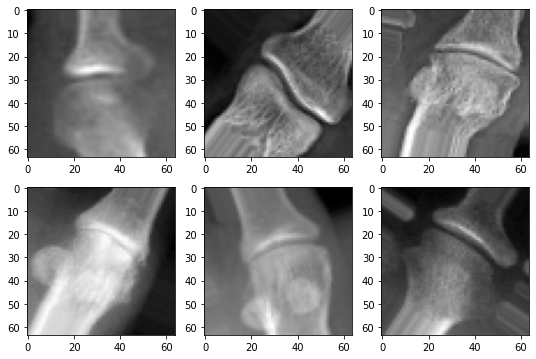

Displaying images normalized to [0, 1] with mean 2.30968e-07 and std 1.0


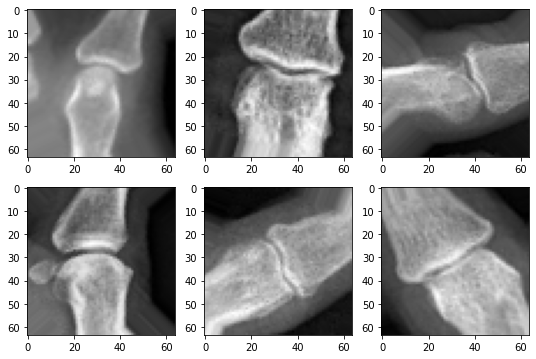

Displaying images normalized to [0, 1] with mean 3.7252903e-09 and std 1.0


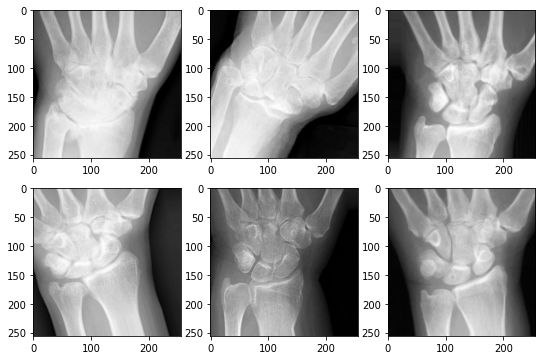

In [160]:
#@title Visualize some augmented samples

def normalize_image(image, nonzero = False):
  a, b = None, None
  if nonzero:
    a = image - np.min(image[image > 0])
    a = np.maximum(a, 0)
  else:
    a = image - np.min(image)
  b = np.max(a) - np.min(a)
  return a / b

def display_generator(gen, data, labels=None, n_cols=3, n_rows=2, scale = 3):

  fig, ax = plt.subplots(figsize=(scale * n_cols, scale * n_rows), ncols=n_cols, nrows=n_rows)

  samples = gen.flow(data, labels, batch_size=n_cols * n_rows).next()

  print('Displaying images normalized to [0, 1] with mean', samples[0].mean(axis=(0,1,2)), 'and std', samples[0].std(axis=(0,1,2)))

  for index, axis in enumerate(ax.flat):
    sample = samples[0][index] if labels else samples[index]
    axis.imshow(normalize_image(sample))
    if labels:
      label = np.argmax(samples[1][index]) if len(samples[1].shape) > 1 else samples[1][index]

      axis.set_xlabel(label)
    
  plt.show()

display_generator(feet_erosion_train_datagen, feet_joints)
display_generator(hand_erosion_train_datagen, finger_joints)
display_generator(wrist_erosion_train_datagen, wrist_common_joints)


In [0]:
Folds generation and data preparation

In [0]:
#@title Modular live loss plotter callback

#Modular live loss plotter for Keras models
#Allows to create custom layouts of per-batch or per-epoch plots for different metrics

#Monitor class defines a plot, which either may be batch or epoch-scoped, and may contain several graphs
#Batch monitor plots its values per batch, and refreshes itself on new epoch begin
#Epoch monitor plots its values per epoch, and performs no refresh
#All values/last N values displaying
#Log-scale/Linear scale displaying

#Plotter callback handles different Monitors and responds to the actual plotting
#Defines a grid where Monitors will be drawn, grid size, refresh rate in batches
#when the Monitors will be re-drawn in addition to per-epoch update
#Plotter can be silenced to disable plotting and only archivate per-epoch data

from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class Monitor():
    def __init__(self, scope='epoch', monitors= [ 'loss' ], plot_last=-1, log_scale=False, precision=4):
        self.scope = scope.lower()
        self.monitors = [ monitor.lower() for monitor in monitors ]
        self.plot_last = max(0, plot_last)
        self.x = []
        self.ys = [ [] for monitor in monitors ]
        self.log_scale = log_scale
        self.precision = precision

    def reinit(self):
        self.x = []
        self.ys = [ [] for monitor in self.monitors ]

    def update(self, iteration, logs={}):
        self.x.append(iteration)
        
        for i, monitor in enumerate(self.monitors):
            if logs.get(monitor) is not None:
                self.ys[i].append(logs.get(monitor))
            else:
                pass #Action to execute when cannot get info for a certain monitor

    def plot(self, axis):
        x_data = self.x[ -self.plot_last : ]
        y_array = [ y_data[ -self.plot_last : ] for y_data in self.ys ]

        for i, y_data in enumerate(y_array):
            label = self.monitors[i] + '_' + self.scope #Compose graph name
            if self.log_scale:
                axis.set_yscale('log') #Set up scale
                
            if len(x_data) == len(y_data): #If data are coherent, plot them
                axis.plot(x_data, y_data, label=label)

                if self.precision > 0 and len(y_data) > 0: #If there's a last point plotted, print its value
                    text = str(round(y_data[-1],  self.precision))
                    axis.text(x_data[-1], y_data[-1], text)
            else:
                continue
                
        label = {'batch' : 'Batches', 'epoch' : 'Epochs'} #Set up x-label
        axis.set_xlabel(label[self.scope])
        
        axis.legend()


class Plotter(Callback):
    def __init__(self, scale=5, n_cols=2, n_rows=1, monitors=[], refresh_rate=-1, silent=False):
        if (n_cols * n_rows < len(monitors)):
            raise ValueError('Grid is too small to fit all monitors!')

        self.n_cols = n_cols
        self.n_rows = n_rows
        self.scale = scale

        self.monitors = monitors

        self.batch_monitors, self.epoch_monitors = [], []

        for monitor in monitors:
            if monitor.scope == 'epoch':
                self.epoch_monitors.append(monitor)
            elif monitor.scope == 'batch':
                self.batch_monitors.append(monitor)

        self.refresh_rate = refresh_rate
        self.silent = False

    def on_train_begin(self, logs={}):
        pass

    def on_epoch_begin(self, epoch, logs={}):
        [ monitor.reinit() for monitor in self.batch_monitors ]

    def plot(self):
        clear_output(wait=True)

        figsize = ( self.scale * self.n_cols, self.scale * self.n_rows)
        fig, ax = plt.subplots(figsize=figsize, ncols=self.n_cols, nrows=self.n_rows)

        if self.n_cols * self.n_rows == 1:
          ax = np.array([ax])

        for index, axis in enumerate(ax.flat):
          if index < len(self.monitors):
              self.monitors[index].plot(axis)

        plt.show()

    def on_batch_end(self, batch, logs={}):
        [ monitor.update(batch, logs) for monitor in self.batch_monitors ]

        if self.silent or batch == 0 or self.refresh_rate <= 0 or batch % self.refresh_rate != 0:
            return

        self.plot()

    def on_epoch_end(self, epoch, logs={}):
        [ monitor.update(epoch, logs) for monitor in self.epoch_monitors ]

        if self.silent:
            return

        self.plot()

    def reinit(self):
      [ monitor.reinit() for monitor in self.monitors ]


In [0]:
#@title Batch sizes and step counts

TODO: Individual batch sizes array

batch_size = 512 // (x_train.shape[1] // 32) ** 2 #Reduce in case of memory issues
steps_per_epoch = max(
    1, x_train.shape[0] // batch_size
)

val_batch_size = min(y_val.shape[0], 1024 // (x_train.shape[1] // 64) ** 2)
validation_steps = max(
    1, x_val.shape[0] // val_batch_size  #Validate on full set
)